In [1]:
#Solving the Bloch equations


"""
Created: Feb. 4th, 2019
Last modification: Feb. 5th, 2019
MORGADO, Manuel (M2-MCN , QMAT fellow)
U. Strasbourg // ISIS // IPCMS
Supervisor. Prf. Dr. S. Whitlock

This solve the Bloch optical equation for a given value of the parameters:
gamma, n, rabi_freq and delta (decay rate, number of thermal photons, Rabi's
frequency) by using the scipy built-in command for solve differential equations
such as odeint from scipy https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html

Moreover, the plot for the different values of the decay and detuning haven being
perform.

(gamma = 0.0 ; delta = 0.0
gamma = 0.0 ; delta = 4*Omega_R
gamma = 0.2*Omega_R ; delta = 0.0
gamma = 2*Omega_R ; delta = 0.0)
"""

#importing lybraries 
import numpy as np
from scipy.integrate import odeint
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from mpl_toolkits.mplot3d import Axes3D


In [2]:
#general parameters
'''
gamma : it is decay rate from 2->1 (float) [units]
n : the number of thermal photons (float) [units]
omega : Rabi's frequency or usually denoted as Omega_R (float)[units]
delta : detuning (float) [units]
g_decay : decay rate from 2->x wherex is somethingelse to 
'''

omega = np.complex(input("Introduce a value for the Rabi frequency: ")); #for a given value of the Rabi frequency
g_decay = [0.01*omega, 0.25*omega, 0.75*omega, 15*omega]; #for a set of values of decay rate

# omega = np.linspace(0,5,10, dtype=np.complex_);
# g_decay = np.linspace(0,3,500);

gamma = [0.0, 0.0, 0.2*omega, 2*omega];
delta = [0.0, 4*omega, 0.0, 0.0];
n = 0.0;

Introduce a value for the Rabi frequency: 1.75


In [3]:
#definition of solver of complex diferential equations system based in 'oint' (scipy) for 
# solve the real part of the system.
'''
Internal function for odeint in complex DE took from: 
https://stackoverflow.com/questions/19910189/scipy-odeint-with-complex-initial-values 
'''
def odeintz(func, z0, t, **kwargs):
    """An odeint-like function for complex valued differential equations."""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [4]:
#bloch optical equations
def bloch_eq(rho,t):
    r11 = rho[0]
    r12 = rho[1];
    r22 = rho[2];

    # dr11dt = ((-1j)*(np.conjugate(om))*(np.conjugate(r12))) + ((1j)*(om)*(r12)) + ((g)*(r22)) + ((n)*(g)*(r22)) - ((n)*(g)*(r11));
    dr11dt = (-1j)*(np.conjugate(om))*(np.conjugate(r12)) + (1j)*(om)*(r12) + (g)*(n+1)*(r22) - (n)*(g)*(r11);
    #Adding a decay term of the population for r22
    # dr12dt = ((-1)*(1j)*(d)*(r12)) - ((1j)*(np.conjugate(om))*(r22-r11)) - (((0.5)*(g)*((2*n)+1)*(r12))) - ((1j)*(g_decay)*(r12));
    dr12dt = (r12)*((-1j)*(d) - (0.5)*(g)*(2*n+1) - (1)*(gd)) - (1j)*(np.conjugate(om))*(r22-r11);
    #Now the r11+r22=1 doesnt hold anymore
    # dr22dt = ((1j)*(np.conjugate(om))*(np.conjugate(r12))) - ((1j)*(om)*(r12)) - ((n)*(g)*(r22)) - ((g)*(r22)) + ((n)*(g)*(r11)) - ((1j)*(g_decay)*(r22));
    dr22dt = (1j)*(np.conjugate(om))*(np.conjugate(r12)) - (1j)*(om)*(r12) - ( (n)*(g) + (g) + ((1)*(gd)) )*(r22) + (n)*(g)*(r11);
    return [dr11dt, dr12dt, dr22dt]

In [5]:
#differential equation parameters
'''
t : linespace for the horizontal axis (time parameter)
rho : density matrix [(r11, r12);(r21,222)]

With initial conditions where initially the system it is in the ground-state
r11[0]=0; r12[0]=0; r21[0]=0; r22[0]=1;
'''
rho0 = [0.0, 0.0, 1.0];
t = np.linspace(0,10,500)
rho11 = list();
rho12 = list();
rho22 = list();
rhoT = list();

In [17]:
#loop for the different values of gamma, delta, omega and gamma decay
for k in range(4):

    om = omega;
    gd = g_decay[k];
    # print(om, '|| ', type(om))
    # print(gd, '||', type(gd))


    g = gamma[1];
    d = delta[1];

    #solving the differential equation
    rho, infodict = odeintz(bloch_eq, rho0, t, full_output=True);

    #storing the k-th results for r12 and r22
    r11 = rho[:,0]
    r12 = rho[:,1];
    r22 = rho[:,2];

    #stacking in the data
    rho11.append(r11)
    rho12.append(r12);
    rho22.append(r22);

    #rho22 at certain time
    # rhoT.append(r22[350]);

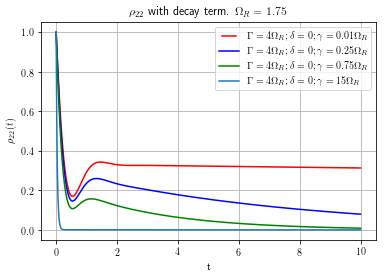

In [18]:
#ploting
plt.figure('rho22')
f1, = plt.plot(t, rho22[0], 'r-', label=r'\Gamma = 4\Omega_R; \delta =  0; \gamma = 0.01\Omega_R')
f2, = plt.plot(t, rho22[1], 'b-', label=r'\Gamma = 4\Omega_R; \delta =  0; \gamma = 0.25\Omega_R')
f3, = plt.plot(t, rho22[2], 'g-', label=r'\Gamma = 4\Omega_R; \delta =  0; \gamma = 0.75\Omega_R')
f4, = plt.plot(t, rho22[3], '-', label=r'\Gamma = 4\Omega_R; \delta =  0; \gamma = 15\Omega_R')
plt.legend(handler_map={f1: HandlerLine2D(numpoints=4)})
plt.title(r'$\rho_{22}$ with decay term. $\Omega_R=1.75$')
plt.ylabel(r'\rho_{22}(t)')
plt.xlabel('t')
plt.grid()

# fig = plt.figure('rho22 (omega, gdecay) @ t=1.75')
# ax = fig.gca(projection='3d')
# ax.plot_trisurf(np.real(omega), np.real(g_decay), np.real(rhoT))

# plt.figure('rho12')
# g1, = plt.plot(t, rho12[0], 'r-', label=r'\Gamma = 0; \delta =  0')
# g2, = plt.plot(t, rho12[1], 'b-', label=r'\Gamma = 0; \delta =  4\Omega_R')
# g3, = plt.plot(t, rho12[2], 'g-', label=r'\Gamma = 0.2\Omega_R; \delta = 0')
# g4, = plt.plot(t, rho12[3], '-', label=r'\Gamma = 2\Omega_R; \delta =  0')
# plt.legend(handler_map={g1: HandlerLine2D(numpoints=4)})
# # plt.legend(loc='best')
# plt.ylabel(r'\rho_{12}(t)')
# plt.xlabel('t')
# plt.grid()


plt.show()